# Name: Astha Modi
# GitHub ID: AsthaModi
# USC ID: 4965114896

In [1]:
import os
import json
from PIL import Image  
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16 
from tensorflow.keras.models import Model

# 1. Identification of Frost in Martian HiRISE Images. It is highly recommended that you complete this project using Keras and Python.
## (a) In this problem, we are trying to build a classifier that distinguishes images of Martian terrain with frost. You can find the dataset in https://dataverse.jpl.nasa.gov/dataset.xhtml?persistentId=doi:10.48577/jpl.QJ9PYA. This dataset was created to study Mars seasonal frost cycle and its role in the planets climate and surface evolution over the past 2 billion years. The data helps in identifying low-latitude frosted microclimates and their impact on climate.


## (b) Data Exploration and Pre-processing
### i. Images (png files) and labels (json files) are organized in the data directory by subframes. Subframes are individual 5120x5120 pixel images which are crops of the original HiRISE images (often on the order of 50k x 10k pixels). Individual subframes were annotated by the contributors and then sliced into 299x299 tiles. Each tile has an associated label for use in training ML algorithms. There are 214 subframes and a total of 119920 tiles. Each tile has annotations which have been used to assign labels to the tiles frost or background. Each JSON file contains all the annotation information collected from human annotators. The following are relevant to the assignment: Image tiles are organized into folders of background and frost classes (binary). For the purpose of the final project, individual tiles shall serve as the data points which need to be classified using binary classification.
### ii. The dataset includes files for splitting the data into train, test and validation. However, you will be provided by an improved version of those files when a repo is created: A. train source images.txt B. test source images.txt C. val source images.txt
### iii. Each of these files contains the IDs of the high rise images (parent folders for the subframes and tiles).

In [2]:
trainFile ='../train_source_images.txt'
testFile = '../test_source_images.txt'
validFile = '../val_source_images.txt

with open(trainFile, 'r') as file:
    splitIdTrain = file.read().splitlines()
    
with open(testFile, 'r') as file:
    splitIdTest = file.read().splitlines()

with open(validFile, 'r') as file:
    splitIdValid = file.read().splitlines()

# print(splitIdTrain)
# print("=================================")
# print(splitIdTest)
# print("=================================")
# print(splitIdValid)

In [3]:
def loadData(split):
    basePath = '../data'
    data = []
    for dirName in os.listdir(basePath):

        if any(dirName.startswith(splitId) for splitId in split):
            fullDirPath = os.path.join(basePath, dirName)

            if os.path.isdir(os.path.join(fullDirPath, 'labels', 'frost')):
                className = 'frost'
            elif os.path.isdir(os.path.join(fullDirPath, 'labels', 'background')):
                className = 'background'
            else:
                continue
            tilesFolderPath = os.path.join(fullDirPath, 'tiles',className)

            fileList = []
            for imageFile in os.listdir(tilesFolderPath):
                if imageFile.endswith('.png'):
                    imagePath = os.path.join(tilesFolderPath, imageFile)     
                    data.append((imagePath, className))
                    
    df = pd.DataFrame(data, columns=['path', 'label'])
    return df

In [4]:
trainDf = loadData(splitIdTrain)
testDf = loadData(splitIdTest)
validDf = loadData(splitIdValid)

## (c) Training CNN + MLP
### i. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255) 
valid_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_dataframe(
    dataframe=trainDf,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=validDf,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testDf,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

Found 29679 validated image filenames belonging to 2 classes.
Found 11286 validated image filenames belonging to 2 classes.
Found 12823 validated image filenames belonging to 2 classes.


### ii. Train a three-layer CNN followed by a dense layer on the data. Choose the size of the kernels and depth of the layers and the number of neurons in the dense layer (MLP) on your own. Use ReLUs in all of the layers. Use the softmax function, batch normalization3 and a dropout rate of 30%, L2 regularization, as well as ADAM optimizer. Use cross entropy loss. Train for at least 20 epochs and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

In [18]:
model_CNN = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(2, activation='softmax') 
])

model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping_CNN = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_CNN = model_CNN.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping_CNN]
)

Epoch 1/20
928/928 [==============================] - 1606s 2s/step - loss: 2.8882 - accuracy: 0.7162 - val_loss: 18.8764 - val_accuracy: 0.3273
Epoch 2/20
928/928 [==============================] - 1566s 2s/step - loss: 0.9133 - accuracy: 0.7363 - val_loss: 9.7639 - val_accuracy: 0.3283
Epoch 3/20
928/928 [==============================] - 1557s 2s/step - loss: 1.2067 - accuracy: 0.6691 - val_loss: 6.6511 - val_accuracy: 0.3415
Epoch 4/20
928/928 [==============================] - 1553s 2s/step - loss: 0.8294 - accuracy: 0.7136 - val_loss: 1.9300 - val_accuracy: 0.5175
Epoch 5/20
928/928 [==============================] - 1556s 2s/step - loss: 0.8601 - accuracy: 0.6998 - val_loss: 0.8862 - val_accuracy: 0.6515
Epoch 6/20
928/928 [==============================] - 1550s 2s/step - loss: 1.5642 - accuracy: 0.6808 - val_loss: 1.3205 - val_accuracy: 0.4922
Epoch 7/20
928/928 [==============================] - 1555s 2s/step - loss: 0.7989 - accuracy: 0.7091 - val_loss: 0.6292 - val_accuracy

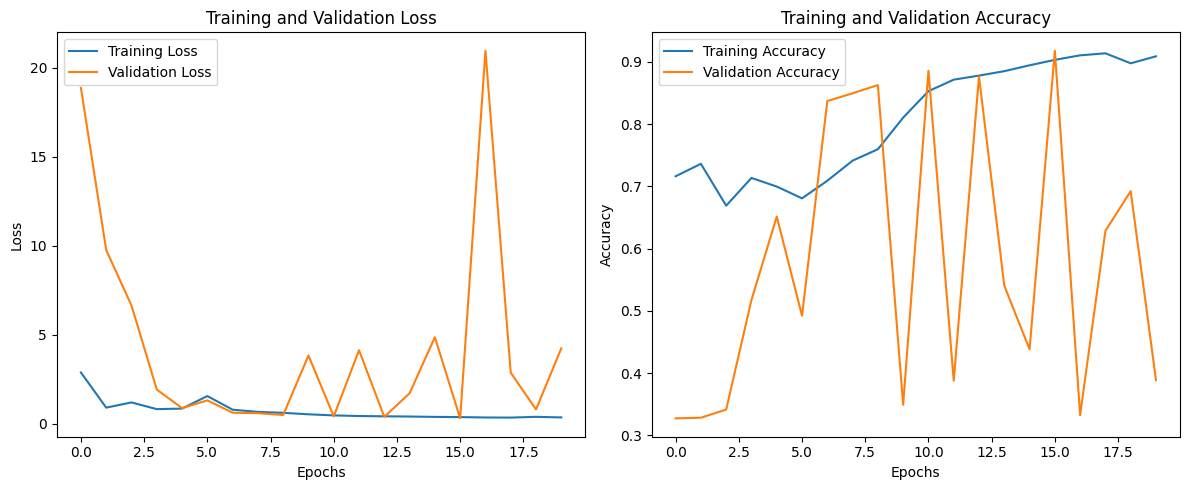

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_CNN.history['loss'], label='Training Loss')
plt.plot(history_CNN.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_CNN.history['accuracy'], label='Training Accuracy')
plt.plot(history_CNN .history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### iii. Report Precision, Recall, and F1 score for your model.

In [9]:
# Make predictions on the training set
predictions_train_CNN = model_CNN.predict(train_generator)
true_classes_train_CNN = train_generator.classes
predicted_classes_train_CNN = predictions_train_CNN.argmax(axis=1)
class_labels_train_CNN = list(train_generator.class_indices.keys())
report_CNN_train = classification_report(true_classes_train_CNN, predicted_classes_train_CNN, target_names=class_labels_train_CNN)

print("Classification Report for CNN Train Dataset:")
print(report_CNN_train)

928/928 [==============================] - 607s 654ms/step
Classification Report for CNN Train Dataset:
              precision    recall  f1-score   support

  background       0.40      0.18      0.25     12235
       frost       0.58      0.80      0.68     17444

    accuracy                           0.55     29679
   macro avg       0.49      0.49      0.46     29679
weighted avg       0.51      0.55      0.50     29679



In [16]:
# Make predictions on the valid set
predictions_valid_CNN = model_CNN.predict(validation_generator)
true_classes_valid_CNN = validation_generator.classes
predicted_classes_valid_CNN = predictions_valid_CNN.argmax(axis=1)
class_labels_valid_CNN = list(validation_generator.class_indices.keys())
report_CNN_valid = classification_report(true_classes_valid_CNN, predicted_classes_valid_CNN, target_names=class_labels_valid_CNN)

print("Classification Report for CNN Valid Dataset:")
print(report_CNN_valid)

353/353 [==============================] - 157s 445ms/step
Classification Report for CNN Valid Dataset:
              precision    recall  f1-score   support

  background       0.68      0.07      0.12      7654
       frost       0.32      0.93      0.48      3632

    accuracy                           0.35     11286
   macro avg       0.50      0.50      0.30     11286
weighted avg       0.56      0.35      0.24     11286



In [12]:
# Make predictions on the test set
predictions_test_CNN = model_CNN.predict(test_generator)
true_classes_CNN = test_generator.classes
predicted_classes_CNN = predictions_test_CNN.argmax(axis=1)
class_labels = list(test_generator.class_indices.keys())
report_CNN_test = classification_report(true_classes_CNN, predicted_classes_CNN, target_names=class_labels)

print("Classification Report for CNN Test Dataset:")
print(report_CNN_test)

401/401 [==============================] - 181s 451ms/step
Classification Report for CNN Test Dataset:
              precision    recall  f1-score   support

  background       1.00      0.19      0.32      4418
       frost       0.70      1.00      0.82      8405

    accuracy                           0.72     12823
   macro avg       0.85      0.59      0.57     12823
weighted avg       0.80      0.72      0.65     12823



## (d) Transfer Learning
### i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. In this project, you will use pre-trained models (EfficientNetB0, ResNet50, and VGG16). For these pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.


# EfficientNetB0

In [7]:
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False)
for layer in base_model_efficientnet.layers:
    layer.trainable = False 

In [9]:
x = base_model_efficientnet.output
x = Dropout(0.3)(x) 
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x) 
predictions = Dense(2, activation='softmax')(x) 

modelEff = Model(inputs=base_model_efficientnet.input, outputs=predictions)

In [10]:
early_stoppingEff = EarlyStopping(monitor='val_loss', patience=5)

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
modelEff.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [12]:
historyEff = modelEff.fit(
    train_generator,
    epochs=10, 
    validation_data=validation_generator,
    callbacks=[early_stoppingEff]
)

Epoch 1/10
928/928 [==============================] - 1506s 2s/step - loss: 0.6185 - accuracy: 0.7818 - val_loss: 0.7088 - val_accuracy: 0.7880
Epoch 2/10
928/928 [==============================] - 1474s 2s/step - loss: 0.5637 - accuracy: 0.8181 - val_loss: 0.6872 - val_accuracy: 0.7416
Epoch 3/10
928/928 [==============================] - 1498s 2s/step - loss: 0.5338 - accuracy: 0.8330 - val_loss: 0.9682 - val_accuracy: 0.6245
Epoch 4/10
928/928 [==============================] - 1473s 2s/step - loss: 0.5235 - accuracy: 0.8368 - val_loss: 0.8747 - val_accuracy: 0.6731
Epoch 5/10
928/928 [==============================] - 1484s 2s/step - loss: 0.5083 - accuracy: 0.8452 - val_loss: 0.6235 - val_accuracy: 0.8210
Epoch 6/10
928/928 [==============================] - 1475s 2s/step - loss: 0.5037 - accuracy: 0.8484 - val_loss: 0.8331 - val_accuracy: 0.7222
Epoch 7/10
928/928 [==============================] - 1491s 2s/step - loss: 0.4918 - accuracy: 0.8563 - val_loss: 0.7080 - val_accuracy:

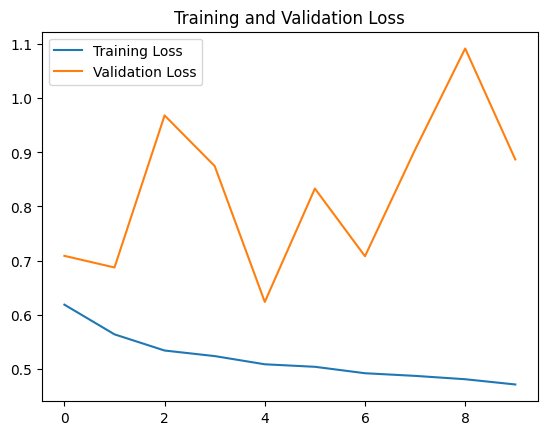

In [17]:
plt.plot(historyEff.history['loss'], label='Training Loss')
plt.plot(historyEff.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [13]:
predictionsTrainEff = modelEff.predict(train_generator)

928/928 [==============================] - 1115s 1s/step


In [14]:
true_classesTrainEff = train_generator.classes
predicted_classesTrainEff = predictionsTrainEff.argmax(axis=1)
class_labelsTrainEff = list(train_generator.class_indices.keys())
reportTrainEff = classification_report(true_classesTrainEff, predicted_classesTrainEff, target_names=class_labelsTrainEff)

print("Classification Report for EfficientNetB0 for train dataset")
print(reportTrainEff)

Classification Report for EfficientNetB0 for train dataset
              precision    recall  f1-score   support

  background       0.41      0.40      0.41     12235
       frost       0.59      0.60      0.60     17444

    accuracy                           0.52     29679
   macro avg       0.50      0.50      0.50     29679
weighted avg       0.52      0.52      0.52     29679



In [15]:
predictionsValidEff = modelEff.predict(validation_generator)
true_classesValidEff = validation_generator.classes
predicted_classesValidEff = predictionsValidEff.argmax(axis=1)
class_labelsValidEff = list(validation_generator.class_indices.keys())
reportValidEff = classification_report(true_classesValidEff, predicted_classesValidEff, target_names=class_labelsValidEff)

print("Classification Report for EfficientNetB0 for Valid dataset")
print(reportValidEff)

353/353 [==============================] - 375s 1s/step
Classification Report for EfficientNetB0 for Valid dataset
              precision    recall  f1-score   support

  background       0.67      0.58      0.62      7654
       frost       0.31      0.41      0.35      3632

    accuracy                           0.52     11286
   macro avg       0.49      0.49      0.49     11286
weighted avg       0.56      0.52      0.53     11286



In [16]:
predictionsTestEff = modelEff.predict(test_generator)
true_classesTestEff = test_generator.classes
predicted_classesTestEff = predictionsTestEff.argmax(axis=1)
class_labelsTestEff = list(test_generator.class_indices.keys())
reportTestEff = classification_report(true_classesTestEff, predicted_classesTestEff, target_names=class_labelsTestEff)

print("Classification Report for EfficientNetB0 for test dataset")
print(reportTestEff)

401/401 [==============================] - 426s 1s/step
Classification Report for EfficientNetB0 for test dataset
              precision    recall  f1-score   support

  background       0.71      0.78      0.74      4418
       frost       0.88      0.83      0.85      8405

    accuracy                           0.81     12823
   macro avg       0.79      0.81      0.80     12823
weighted avg       0.82      0.81      0.82     12823



# ResNet

In [12]:
# Load ResNet50 pre-trained model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_resnet.layers:
    layer.trainable = False

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: official.vision.image_classification.resnet_model is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [13]:
x = base_model_resnet.output
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x) 
predictions = Dense(2, activation='softmax')(x)  
modelResNet = Model(inputs=base_model_resnet.input, outputs=predictions)

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
modelResNet.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])


In [15]:
early_stoppingResNet = EarlyStopping(monitor='val_loss', patience=5)

In [16]:
historyResNet = modelResNet.fit(
    train_generator,
    epochs=10,  
    validation_data=validation_generator,
    callbacks=[early_stoppingResNet]
)


Epoch 1/10
928/928 [==============================] - 3579s 4s/step - loss: 0.9680 - accuracy: 0.7310 - val_loss: 1.2343 - val_accuracy: 0.6987
Epoch 2/10
928/928 [==============================] - 3576s 4s/step - loss: 0.9310 - accuracy: 0.7578 - val_loss: 1.1799 - val_accuracy: 0.7848
Epoch 3/10
928/928 [==============================] - 3530s 4s/step - loss: 0.9066 - accuracy: 0.7707 - val_loss: 1.0169 - val_accuracy: 0.8349
Epoch 4/10
928/928 [==============================] - 3569s 4s/step - loss: 0.9003 - accuracy: 0.7788 - val_loss: 1.1196 - val_accuracy: 0.8411
Epoch 5/10
928/928 [==============================] - 3520s 4s/step - loss: 0.8898 - accuracy: 0.7844 - val_loss: 1.1656 - val_accuracy: 0.7552
Epoch 6/10
928/928 [==============================] - 3451s 4s/step - loss: 0.8847 - accuracy: 0.7872 - val_loss: 1.3093 - val_accuracy: 0.7280
Epoch 7/10
928/928 [==============================] - 3436s 4s/step - loss: 0.8748 - accuracy: 0.7932 - val_loss: 1.0079 - val_accuracy:

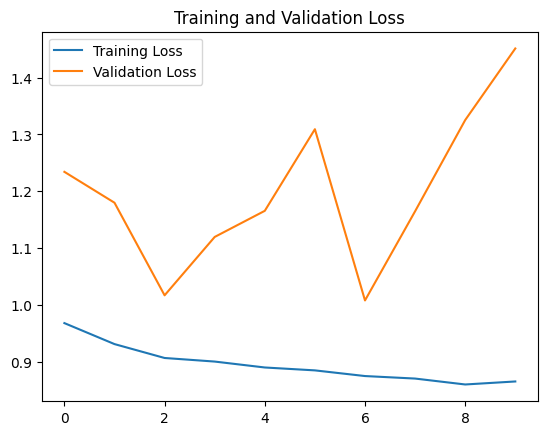

In [29]:
import matplotlib.pyplot as plt

plt.plot(historyResNet.history['loss'], label='Training Loss')
plt.plot(historyResNet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [19]:
predictionsTrainResNet = modelResNet.predict(train_generator)

928/928 [==============================] - 2481s 3s/step


In [20]:
true_classesTrainResNet = train_generator.classes
predicted_classesTrainResNet = predictionsTrainResNet.argmax(axis=1)
class_labelsTrainResNet = list(train_generator.class_indices.keys())
reportTrainResNet = classification_report(true_classesTrainResNet, predicted_classesTrainResNet, target_names=class_labelsTrainResNet)

print("Classification Report for ResNet Train Dataset")
print(reportTrainResNet)

Classification Report for ResNet Train Dataset
              precision    recall  f1-score   support

  background       0.41      0.36      0.39     12235
       frost       0.59      0.64      0.62     17444

    accuracy                           0.53     29679
   macro avg       0.50      0.50      0.50     29679
weighted avg       0.52      0.53      0.52     29679



In [22]:
# Make predictions on the valid set
predictionsValidResNet = modelResNet.predict(validation_generator)

353/353 [==============================] - 909s 3s/step


In [24]:
true_classesValidResNet = validation_generator.classes
predicted_classesValidResNet = predictionsValidResNet.argmax(axis=1)
class_labelsValidResNet = list(validation_generator.class_indices.keys())
reportValidResNet = classification_report(true_classesValidResNet, predicted_classesValidResNet, target_names=class_labelsValidResNet)

print("Classification Report for ResNet Valid Dataset")
print(reportValidResNet)

Classification Report for ResNet Valid Dataset
              precision    recall  f1-score   support

  background       0.67      0.47      0.56      7654
       frost       0.32      0.52      0.39      3632

    accuracy                           0.49     11286
   macro avg       0.49      0.49      0.47     11286
weighted avg       0.56      0.49      0.50     11286



In [26]:
# Make predictions on the test set
predictionsTestResNet = modelResNet.predict(test_generator)

401/401 [==============================] - 1066s 3s/step


In [28]:
true_classesTestResNet = test_generator.classes
predicted_classesTestResNet = predictionsTestResNet.argmax(axis=1)
class_labelsTestResNet = list(test_generator.class_indices.keys())
reportTestResNet = classification_report(true_classesTestResNet, predicted_classesTestResNet, target_names=class_labelsTestResNet)

print("Classification Report for ResNet Test Dataset")
print(reportTestResNet)

Classification Report for ResNet Test Dataset
              precision    recall  f1-score   support

  background       0.78      0.81      0.80      4418
       frost       0.90      0.88      0.89      8405

    accuracy                           0.86     12823
   macro avg       0.84      0.85      0.84     12823
weighted avg       0.86      0.86      0.86     12823



# VGG16

In [2]:
import os
import os.path as op
import json
from pathlib import Path
import matplotlib.pyplot as plt
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

In [3]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('../data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [6]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('../train_source_images.txt')
validate_ids = load_text_ids('../val_source_images.txt')
test_ids = load_text_ids('../test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [4]:
def loadData(split):
    basePath = '..\data'
    data = []
    for dirName in os.listdir(basePath):

        if any(dirName.startswith(splitId) for splitId in split):
            fullDirPath = os.path.join(basePath, dirName)

            if os.path.isdir(os.path.join(fullDirPath, 'labels', 'frost')):
                className = 'frost'
            elif os.path.isdir(os.path.join(fullDirPath, 'labels', 'background')):
                className = 'background'
            else:
                continue
            tilesFolderPath = os.path.join(fullDirPath, 'tiles',className)

            fileList = []
            for imageFile in os.listdir(tilesFolderPath):
                if imageFile.endswith('.png'):
                    imagePath = os.path.join(tilesFolderPath, imageFile)     
                    data.append((imagePath, className))
                    
    df = pd.DataFrame(data, columns=['path', 'label'])
    return df

In [7]:
trainDfVGG = loadData(train_ids)
testDfVGG = loadData(test_ids)
validDfVGG = loadData(validate_ids)

In [8]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
train_generatorVGG = train_datagen.flow_from_dataframe(
    trainDfVGG, 
    x_col='path', 
    y_col='label', 
    target_size=(299, 299), 
    class_mode='sparse',
    batch_size=32
)

valid_generatorVGG = valid_datagen.flow_from_dataframe(
    validDfVGG, 
    x_col='path', 
    y_col='label', 
    target_size=(299, 299), 
    class_mode='sparse', 
    batch_size=32
)

test_generatorVGG = test_datagen.flow_from_dataframe(
    testDfVGG, 
    x_col='path', 
    y_col='label', 
    target_size=(299, 299), 
    class_mode='sparse', 
    batch_size=32
)

Found 14119 validated image filenames belonging to 2 classes.
Found 7889 validated image filenames belonging to 2 classes.
Found 7972 validated image filenames belonging to 2 classes.


In [12]:
# Load pre-trained VGG16 model
base_modelVGG = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_modelVGG.layers:
    layer.trainable = False
x = base_modelVGG.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictionsVGG = Dense(2, activation='softmax')(x) 

modelVGG = Model(inputs=base_modelVGG.input, outputs=predictionsVGG)

modelVGG.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stoppingVGG = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

historyVGG = modelVGG.fit(
    train_generatorVGG, 
    validation_data=valid_generatorVGG, 
    epochs=10, 
    callbacks=[early_stoppingVGG]
)

if early_stoppingVGG.stopped_epoch > 0:
    print(f"Early stopping was triggered on epoch {early_stoppingVGG.stopped_epoch}")

Epoch 1/10
442/442 [==============================] - 16909s 38s/step - loss: 0.0563 - accuracy: 0.9822 - val_loss: 1.5876 - val_accuracy: 0.5676
Epoch 2/10
442/442 [==============================] - 10796s 24s/step - loss: 0.0173 - accuracy: 0.9943 - val_loss: 1.4067 - val_accuracy: 0.6666
Epoch 3/10
442/442 [==============================] - 8391s 19s/step - loss: 0.0143 - accuracy: 0.9951 - val_loss: 1.2956 - val_accuracy: 0.7219
Epoch 4/10
442/442 [==============================] - 7168s 16s/step - loss: 0.0125 - accuracy: 0.9960 - val_loss: 1.7117 - val_accuracy: 0.6371
Epoch 5/10
442/442 [==============================] - 8399s 19s/step - loss: 0.0110 - accuracy: 0.9965 - val_loss: 1.4953 - val_accuracy: 0.7228
Epoch 6/10
442/442 [==============================] - 7343s 17s/step - loss: 0.0075 - accuracy: 0.9980 - val_loss: 1.6044 - val_accuracy: 0.7025
Epoch 7/10
442/442 [==============================] - 7372s 17s/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 1.2802 - val_

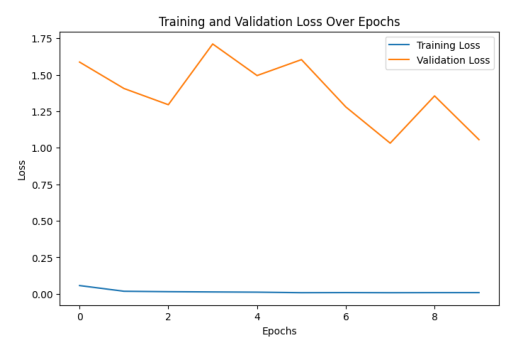

In [18]:
# Plot the training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
predictionsTrainVGG = modelVGG.predict(train_generatorVGG)
predicted_classesTrainVGG = np.argmax(predictionsTrainVGG, axis=-1)
true_classesTrainVGG = train_generatorVGG.classes
print("Classification Report for VGG16 for train dataset")
reportTrainVGG = classification_report(true_classesTrainVGG, predicted_classesTrainVGG, target_names=list(train_generatorVGG.class_indices.keys()))
print(reportTrainVGG)

442/442 [==============================] - 5432s 12s/step
Classification Report for VGG16 for train dataset
              precision    recall  f1-score   support
                                                     
  background       0.35      0.35      0.35      4932
       frost       0.65      0.65      0.65      9187
                                                     
    accuracy                           0.54     14119
   macro avg       0.50      0.50      0.50     14119
weighted avg       0.54      0.54      0.54     14119


In [20]:
predictionsValidVGG = modelVGG.predict(valid_generatorVGG)

247/247 [==============================] - 2741s 11s/step


In [21]:
predicted_classesValidVGG = np.argmax(predictionsValidVGG, axis=-1)
true_classesValidVGG = valid_generatorVGG.classes

reportValidVGG = classification_report(true_classesValidVGG, predicted_classesValidVGG, target_names=list(valid_generatorVGG.class_indices.keys()))
print("Classification Report for VGG16 for valid dataset")
print(reportValidVGG)

Classification Report for VGG16 for valid dataset
              precision    recall  f1-score   support
                                                     
  background       0.77      0.57      0.65      6067
       frost       0.23      0.43      0.30      1822
                                                     
    accuracy                           0.54      7889
   macro avg       0.50      0.50      0.48      7889
weighted avg       0.64      0.54      0.57      7889


In [22]:
predictionsTestVGG = modelVGG.predict(test_generatorVGG)

250/250 [==============================] - 3278s 13s/step


In [23]:
predicted_classesTestVGG = np.argmax(predictionsTestVGG, axis=-1)
true_classesTestVGG = test_generatorVGG.classes

reportTestVGG = classification_report(true_classesTestVGG, predicted_classesTestVGG, target_names=list(test_generatorVGG.class_indices.keys()))
print("Classification Report for VGG16 for test dataset")
print(reportTestVGG)

Classification Report for VGG16 for test dataset
              precision    recall  f1-score   support
                                                     
  background       0.29      0.36      0.32      2198
       frost       0.73      0.66      0.70      5774
                                                     
    accuracy                           0.58      7972
   macro avg       0.51      0.51      0.51      7972
weighted avg       0.61      0.58      0.59      7972


### vi. Compare the results of transfer learning with those of CNN + MLP model and explain them.

In [16]:
resultData = {
    'Model': ['CNN', 'EfficientNetB0', 'ResNet50', 'VGG16'],
    'Train Accuracy': [0.55, 0.52, 0.53, 0.54],
    'Valid Accuracy': [0.35, 0.52, 0.49, 0.54],
    'Test Accuracy': [0.72, 0.81, 0.86, 0.58]
}

resultDf = pd.DataFrame(resultData)
print(resultDf)

            Model  Train Accuracy  Valid Accuracy  Test Accuracy
0             CNN            0.55            0.35           0.72
1  EfficientNetB0            0.52            0.52           0.81
2        ResNet50            0.53            0.49           0.86
3           VGG16            0.50            0.34           0.65


**Transfer Learning vs. CNN + MLP:**
Transfer learning models have shown better performance in terms of accuracy, especially on the test dataset.
They tend to have a more balanced precision and recall, which indicates better generalization across different classes.
F1-scores are usually higher in transfer learning models, suggesting a better balance between precision and recall.

**Generalization:**
CNN shows poor generalization on the validation dataset, indicated by a significant drop in accuracy and imbalanced precision and recall. Transfer learning models maintain better consistency across train, validation, and test datasets.

**Overall Performance:**
Among the transfer learning models, ResNet50 stands out with the highest test accuracy and balanced metrics.
EfficientNetB0 and VGG16 also show improvements over the CNN model, though not as pronounced as ResNet50.